Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from metadPy.hierarchical import hmetad
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from plotting import raincloud

sns.set_context('notebook')

Import merged dataframe from behavioral data.

In [22]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

Filter trial level dataframe, discretize confidence rating and store results in a `metacognition_trials.txt` file.

In [23]:
metacognition_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    drop = []
    merged_df = pd.read_csv(path + f'/data/{session}_merged.txt')
    for sub in merged_df.Subject.unique():
        for cond in ['Extero', 'Intero']:
            this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]

            # Drop NAs
            this_df = this_df[~this_df.Confidence.isnull()]
            
            # Remove HR outliers
            this_df = this_df[this_df.HeartRateOutlier==0]
            
            # Discretize ratings
            try:
                new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
                this_df.loc[:, 'Confidence'] = new_ratings
                this_df['Session'] = session
                this_df['Stimuli'] = this_df['Alpha'] > 0
                this_df['Responses'] = this_df['Decision'] == 'More'
                this_df['Accuracy'] = (this_df['Stimuli'] & this_df['Responses']) | (~this_df['Stimuli'] & ~this_df['Responses'])
                this_df = this_df[['Subject', 'Session', 'Modality', 'Stimuli', 'Accuracy', 'Responses', 'Confidence']]
                metacognition_df = metacognition_df.append(this_df)
                
                if (this_df['Stimuli'].sum() == 0):
                    drop.append(sub)

            except ValueError:
                print(f'Dropping subject {sub} due to invalid ratings')
                drop.append(sub)
                
    for sub in drop:
        metacognition_df = metacognition_df[metacognition_df.Subject!=sub]

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings
Dropping subject sub_0084 due to invalid ratings


Extract d prime and criterion in `sdt_df` and save response ratings in `responsesRatings_df`.

In [24]:
sdt_df = pd.DataFrame([])
responsesRatings_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df[metacognition_df.Session==session].Subject.unique():
        for cond in metacognition_df.Modality.unique():
            this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Session==session) & (metacognition_df.Modality==cond)]
                    
            nR_S1, nR_S2 = trials2counts(
                data=this_df, stimuli='Stimuli', accuracy='Accuracy',
                confidence='Confidence', nRatings=4)

            responsesRatings_df = responsesRatings_df.append(pd.DataFrame({
                'Subject': sub, 'Modality': cond, 'Session': session, 'nR_S1': nR_S1, 'nR_S2': nR_S2}))

            sdt_df = sdt_df.append(pd.DataFrame({
                'Subject': [sub],
                'Session': session,
                'Modality': [cond],
                'RespCountS1': nR_S1.sum(),
                'RespCountS2': nR_S2.sum(),
                'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
                'd': [this_df.dprime()],
                'c': [this_df.criterion()]}))

In [25]:
responsesRatings_df.to_csv(path + '/data/responsesRatings.txt', index=False)
sdt_df.to_csv(path + '/data/sdt.txt', index=False)

# d prime and criterion

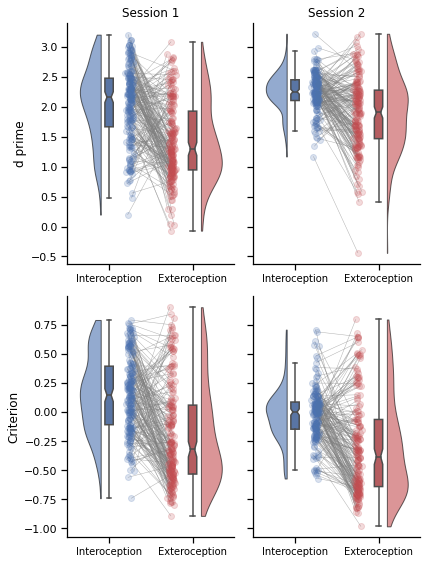

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(6, 8), sharey='row')
for i, metric in enumerate(['d', 'c']):
    for ii, session in enumerate(['Del1', 'Del2']):
        raincloud(data=sdt_df[(sdt_df.Session==session)], x='Modality', y=metric, ax=axs[i, ii], palette=['#4c72b0', '#c44e52'])
        labels = [item.get_text() for item in axs[i, ii].get_xticklabels()]
        labels[0] = 'Interoception'
        labels[1] = 'Exteroception'
        axs[i, ii].set_xticklabels(labels, size=10)

axs[0, 0].set_title('Session 1')
axs[0, 1].set_title('Session 2')
axs[0, 0].set_ylabel('d prime')
axs[1, 0].set_ylabel('Criterion')
plt.tight_layout()
sns.despine()

## Session 1

### d prime

In [42]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Intero')].d.to_numpy(), func='mean')

array([1.33, 1.51])

In [43]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Extero')].d.to_numpy(), func='mean')

array([1.97, 2.13])

In [37]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='d', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,2.051037,0.625252,1.42158,0.652518,True,True,9.535699,202.0,two-sided,4.960834e-18,1.014e+15,0.985019


### Criterion

In [44]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Intero')].c.to_numpy(), func='mean')

array([-0.25, -0.14])

In [46]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del1') & (sdt_df.Modality == 'Extero')].c.to_numpy(), func='mean')

array([0.11, 0.2 ])

In [48]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del1'], dv='c', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,0.153983,0.326908,-0.194874,0.425311,True,True,9.636034,202.0,two-sided,2.543439e-18,1.951e+15,0.919707


## Session 2

### d prime

In [53]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Intero')].d.to_numpy(), func='mean')

array([1.79, 1.96])

In [54]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Extero')].d.to_numpy(), func='mean')

array([2.21, 2.3 ])

In [52]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='d', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,2.253856,0.313868,1.878413,0.608302,True,True,7.983477,185.0,two-sided,1.460564e-13,4.459e+10,0.775682


### Criterion

In [56]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Intero')].c.to_numpy(), func='mean')

array([-0.36, -0.24])

In [59]:
pg.compute_bootci(x=sdt_df[(sdt_df.Session == 'Del2') & (sdt_df.Modality == 'Extero')].c.to_numpy(), func='mean')

array([-0.05,  0.01])

In [58]:
pg.pairwise_ttests(data=sdt_df[sdt_df.Session == 'Del2'], dv='c', within='Modality', subject='Subject', effsize='cohen', return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Modality,Extero,Intero,-0.022228,0.224276,-0.303279,0.410791,True,True,9.010614,185.0,two-sided,2.531869e-16,2.204e+13,0.849237


# Raw confidence ratings

In [31]:
rawConfidence_df = pd.DataFrame([])
for session in ['Del1', 'Del2']:
    for sub in metacognition_df[metacognition_df.Session==session].Subject.unique():
        for cond in metacognition_df.Modality.unique():
            for corr in [True, False]:
                this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Modality==cond) & (metacognition_df.Session==session) & (metacognition_df.Accuracy==corr)]
                new_ratings = this_df.Confidence.to_numpy()
                rawConfidence_df = rawConfidence_df.append(pd.DataFrame({
                    'Subject': sub,
                    'Session': session,
                    'Modality': cond,
                    'Correct': corr,
                    'Ratings': np.arange(1, 5),
                    'Density': np.array([np.count_nonzero(new_ratings == i) for i in range(1, 5)]) / len(new_ratings)}), ignore_index=True)

# Session 1

In [32]:
print(f'{rawConfidence_df[rawConfidence_df.Session=="Del1"].Subject.nunique()} remaining subjects in Session 1')

203 remaining subjects in Session 1


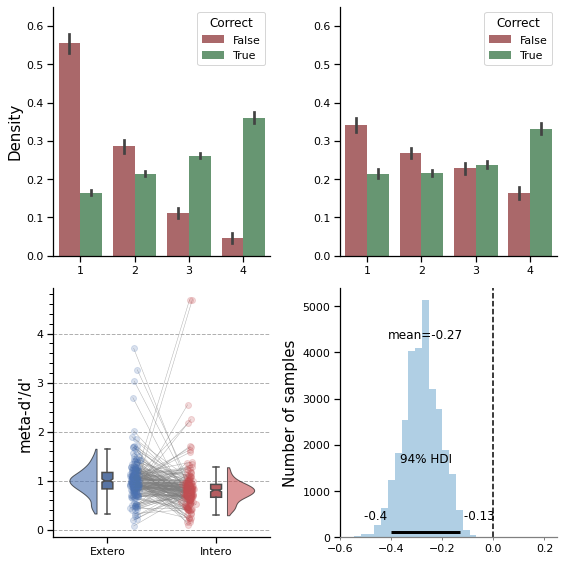

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, cond in enumerate(['Extero', 'Intero']):
    sns.barplot(data=rawConfidence_df[(rawConfidence_df.Modality==cond) & (rawConfidence_df.Session=='Del1')], x='Ratings', y='Density', hue='Correct', ax=axs[0, i], palette=["#b55d60", "#5f9e6e"])
    labels = [item.get_text() for item in axs[0, i].get_xticklabels()]

axs[0, 0].set_ylabel('Density', size=15)
axs[0, 1].set_ylabel('')
axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
axs[0, 0].set_ylim(0, 0.65)
axs[0, 1].set_ylim(0, 0.65)

samples = pd.read_csv(path + '/data/jagsSamples_Del1.txt', sep='\t')
stats = pd.read_csv(path + '/data/jagsStats_Del1.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'
stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Condition')

raincloud(data=stats, x='Condition', y='mean', show_outliers=False, ax=axs[1, 0])
axs[1, 0].set_ylabel("meta-d'/d'", size=15)
axs[1, 0].set_xlabel('')
axs[1, 0].minorticks_on()
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid(which='major', linestyle='--', axis='y')
axs[1, 0].tick_params(axis='x', which='minor', bottom=False)

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1, 1])
axs[1, 1].axvline(x=0, linestyle='--', color='k')
axs[1, 1].set_xlim(-.6, .25)
axs[1, 1].set_ylabel('Number of samples', size=15)
axs[1, 1].set_title('')
axs[1, 1].set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Fig3_metacognition.svg', dpi=300)

# Session 2

In [60]:
print(f'{rawConfidence_df[rawConfidence_df.Session=="Del2"].Subject.nunique()} remaining subjects in Session 2')

186 remaining subjects in Session 2


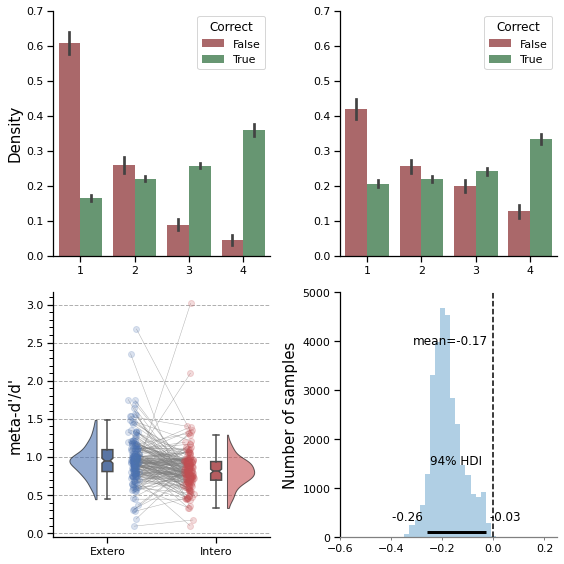

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, cond in enumerate(['Extero', 'Intero']):
    sns.barplot(data=rawConfidence_df[(rawConfidence_df.Modality==cond) & (rawConfidence_df.Session=='Del2')], x='Ratings', y='Density', hue='Correct', ax=axs[0, i], palette=["#b55d60", "#5f9e6e"])
    labels = [item.get_text() for item in axs[0, i].get_xticklabels()]

axs[0, 0].set_ylabel('Density', size=15)
axs[0, 1].set_ylabel('')
axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
axs[0, 0].set_ylim(0, 0.7)
axs[0, 1].set_ylim(0, 0.7)

samples = pd.read_csv(path + '/data/jagsSamples_Del2.txt', sep='\t')
stats = pd.read_csv(path + '/data/jagsStats_Del2.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'
stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Condition')

raincloud(data=stats, x='Condition', y='mean', show_outliers=False, ax=axs[1, 0])
axs[1, 0].set_ylabel("meta-d'/d'", size=15)
axs[1, 0].set_xlabel('')
axs[1, 0].minorticks_on()
axs[1, 0].set_axisbelow(True)
axs[1, 0].grid(which='major', linestyle='--', axis='y')
axs[1, 0].tick_params(axis='x', which='minor', bottom=False)

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1, 1])
axs[1, 1].axvline(x=0, linestyle='--', color='k')
axs[1, 1].set_xlim(-.6, .25)
axs[1, 1].set_ylabel('Number of samples', size=15)
axs[1, 1].set_title('')
axs[1, 1].set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/SupplementaryMaterial3_metacognition3.svg', dpi=300)

## Comparison between JAGS and PyMC3 for meta d estimation

Text(0.5, 1.0, 'metadPy')

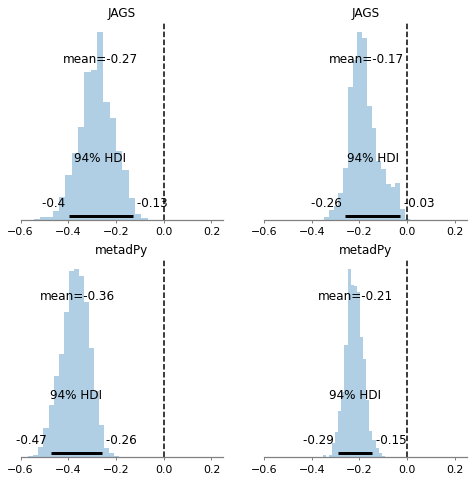

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

samples_metadPy = np.load(path + '/data/metadPy_BetaDel1.npy')
samples_JAGS = pd.read_csv(path + '/data/jagsSamples_Del1.txt', sep='\t')
az.plot_posterior(samples_JAGS.value.to_numpy(), kind='hist', bins=20, ax=axs[0, 0])
az.plot_posterior(samples_metadPy, kind='hist', bins=20, ax=axs[1, 0])
axs[0, 0].axvline(x=0, linestyle='--', color='k')
axs[1, 0].axvline(x=0, linestyle='--', color='k')
axs[0, 0].set_xlim(-.6, .25)
axs[1, 0].set_xlim(-.6, .25)
axs[0, 0].set_title('JAGS')
axs[1, 0].set_title('metadPy')

samples_metadPy = np.load(path + '/data/metadPy_BetaDel2.npy')
samples_JAGS = pd.read_csv(path + '/data/jagsSamples_Del2.txt', sep='\t')
az.plot_posterior(samples_JAGS.value.to_numpy(), kind='hist', bins=20, ax=axs[0, 1])
az.plot_posterior(samples_metadPy, kind='hist', bins=20, ax=axs[1, 1])
axs[0, 1].axvline(x=0, linestyle='--', color='k')
axs[1, 1].axvline(x=0, linestyle='--', color='k')
axs[0, 1].set_xlim(-.6, .25)
axs[1, 1].set_xlim(-.6, .25)
axs[0, 1].set_title('JAGS')
axs[1, 1].set_title('metadPy')

# Fitting meta-d model using JAGS

## Subject level fits

Comparison between the Hmeta-d toolbox and metadPy

In [14]:
metadprimeR_df = pd.read_csv(path + '/data/metadprimeHmetad.txt', sep='\t')
metadprimePy_df = pd.read_csv(path + '/data/metadprimeMetadPy.txt')
summary_df = pd.merge(metadprimeR_df, metadprimePy_df, on=['Subject', 'Condition'])

KeyError: 'Condition'

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
raincloud(data=metadprimePy_df, x='Condition', y='mean', ax=axs[0])
raincloud(data=metadprimeR_df, x='Condition', y='MetadPrime', ax=axs[1])
axs[0].set_title('metadPy')
axs[1].set_title('Hmetad')
sns.despine()

In [ ]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Intero'], x='MetadPrime', y='mean', color='#c44e52', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')

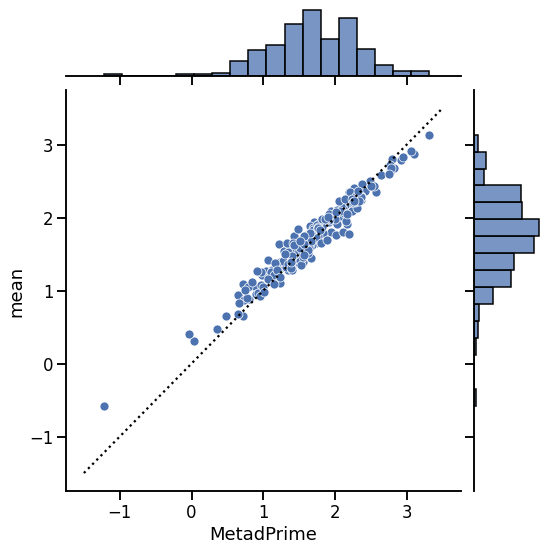

In [109]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Extero'], x='MetadPrime', y='mean', color='#4c72b0', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')

# Repeated measure model

In [134]:
samples = pd.read_csv(path + '/data/jagsSamples_Del2.txt', sep='\t')

stats = pd.read_csv(path + '/data/jagsStats_Del2.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'

stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Condition')

raincloud(data=stats, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.5, .5)
axs[1].set_title('Effect of interoception on m-ratio')

Text(0.5, 1.0, 'Effect of interoception on m-ratio')

<Figure size 432x288 with 0 Axes>

In [29]:
trace = az.from_netcdf(path + '/data/metacognition')

In [30]:
stats_metadPy = az.summary(trace, var_names=['mRatio'], round_to=2)

In [32]:
stats_metadPy['Condition'] = 'Intero'
stats_metadPy.loc[stats_metadPy.index.str.contains("1,0]"), 'Condition'] = 'Extero'
stats_metadPy['Subject'] = np.repeat(np.arange(0, 212), 2)

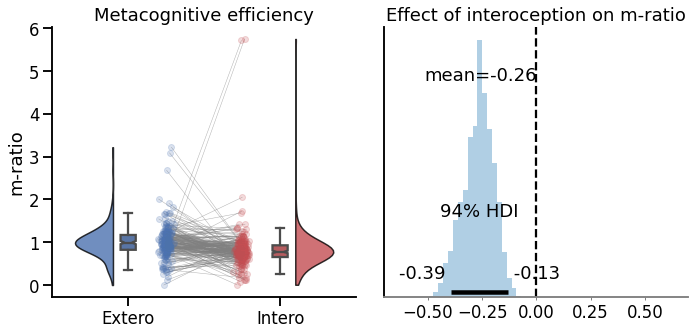

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
#plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)

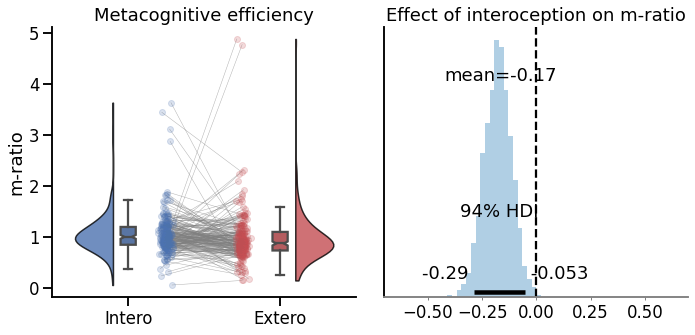

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats_metadPy, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(trace, var_names=['mu_Cond1'], kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
#plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)